This notebook performs the linear Granger causality tests

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import data_preprocessing.data_preprocessing as data
import statsmodels.api as sm

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams['font.family'] = 'Arial'

In [2]:
#Normalisation technique makes no difference for the significance testing of OLS linear regression

#min/max normalised
all_dnas = list((data.all_4d_dnas - np.min(data.all_4d_dnas))/(np.max(data.all_4d_dnas) - np.min(data.all_4d_dnas)))
all_mtvols = list((data.all_4d_mtvols - np.min(data.all_4d_mtvols))/(np.max(data.all_4d_mtvols) - np.min(data.all_4d_mtvols)))
all_cellvols = list((data.all_4d_cellvols - np.min(data.all_4d_cellvols))/(np.max(data.all_4d_cellvols) - np.min(data.all_4d_cellvols)))

#zscaled normalised
all_dnas = list((data.all_4d_dnas - np.mean(data.all_4d_dnas))/(np.std(data.all_4d_dnas)))
all_mtvols = list((data.all_4d_mtvols - np.mean(data.all_4d_mtvols))/(np.std(data.all_4d_mtvols)))
all_cellvols = list((data.all_4d_cellvols - np.mean(data.all_4d_cellvols))/(np.std(data.all_4d_cellvols)))


In [4]:
#creates the predictor and response matrix for linear regression
def create_regression_matrices(lag, response = "dna"):

    if response == "dna":
        res_list = all_dnas
        pred1_list = all_mtvols
        pred2_list = all_cellvols

    elif response == "mtvol":
        res_list = all_mtvols
        pred1_list = all_dnas
        pred2_list = all_cellvols

    elif response == "cellvol":
        res_list = all_cellvols
        pred1_list = all_dnas
        pred2_list = all_mtvols
    else:
        raise Exception("Response doesn't exist")
    
    #n = number of cells
    #m = number of time points
    n = len(res_list)
    m = len(res_list[0])
    k=lag

    #(m-k)*n dimensional
    response_vec = np.array([])
    #(m-k)*n,3*k + 1) dimensional
    predictor_matrix = []
    for i in range(n):
        response_vec = np.concatenate([response_vec, np.flip(res_list[i][k:])]) #T, T-1, ..., T-k

    for i in range(n):
        res = res_list[i]
        pred1 = pred1_list[i]
        pred2 = pred2_list[i]
        sub_predictor_matrix = []
        for j in range(m-k):
            sub_res = np.flip(res[-k-j-1:-j-1]) #-(k+1):-1 to -(m+1):-(m-k+1) 
            sub_pred1 = np.flip(pred1[-k-j-1:-j-1])
            sub_pred2 = np.flip(pred2[-k-j-1:-j-1])
            sub_predictor_matrix.append(np.concatenate([sub_res, sub_pred1, sub_pred2]))

        predictor_matrix.append(np.array(sub_predictor_matrix))
    
    predictor_matrix = np.concatenate(predictor_matrix, axis = 0)
    predictor_matrix = np.concatenate([np.ones(predictor_matrix.shape[0])[:,np.newaxis], predictor_matrix], axis=1)
    # predictor_matrix = predictor_matrix - np.mean(predictor_matrix, axis=0)

    # return response_vec - np.mean(response_vec), predictor_matrix*np.sqrt((m-k)*n)/np.linalg.norm(predictor_matrix, axis = 0)

    return response_vec, predictor_matrix

#creates the predictor and response matrix excluding the ith cell for linear regression validation
def create_without_ith_fold_regression_matrices(lag, fold, response = "dna"):

    if response == "dna":
        res_list = all_dnas.copy()
        _ = res_list.pop(fold)
        pred1_list = all_mtvols.copy()
        _ = pred1_list.pop(fold)
        pred2_list = all_cellvols.copy()
        _ = pred2_list.pop(fold)

    elif response == "mtvol":
        res_list = all_mtvols.copy()
        _ = res_list.pop(fold)
        pred1_list = all_dnas.copy()
        _ = pred1_list.pop(fold)
        pred2_list = all_cellvols.copy()
        _ = pred2_list.pop(fold)

    elif response == "cellvol":
        res_list = all_cellvols.copy()
        _ = res_list.pop(fold)
        pred1_list = all_dnas.copy()
        _ = pred1_list.pop(fold)
        pred2_list = all_mtvols.copy()
        _ = pred2_list.pop(fold)

    else:
        raise Exception("Response doesn't exist")
    
    n = len(res_list)
    m = len(res_list[0])
    k=lag

    #(m-k)*n dimensional
    response_vec = np.array([])
    #(m-k)*n,3*k) dimensional
    predictor_matrix = []
    for i in range(n):
        response_vec = np.concatenate([response_vec, np.flip(res_list[i][k:])])

    for i in range(n):
        res = res_list[i]
        pred1 = pred1_list[i]
        pred2 = pred2_list[i]
        sub_predictor_matrix = []
        for j in range(m-k):
            sub_res = np.flip(res[-k-j-1:-j-1])
            sub_pred1 = np.flip(pred1[-k-j-1:-j-1])
            sub_pred2 = np.flip(pred2[-k-j-1:-j-1])
            sub_predictor_matrix.append(np.concatenate([sub_res, sub_pred1, sub_pred2]))

        predictor_matrix.append(np.array(sub_predictor_matrix))
    
    predictor_matrix = np.concatenate(predictor_matrix, axis = 0)
    predictor_matrix = np.concatenate([np.ones(predictor_matrix.shape[0])[:,np.newaxis], predictor_matrix], axis=1)
    # predictor_matrix = predictor_matrix - np.mean(predictor_matrix, axis=0)

    # return response_vec - np.mean(response_vec), predictor_matrix*np.sqrt((m-k)*n)/np.linalg.norm(predictor_matrix, axis = 0)

    return response_vec, predictor_matrix

#creates the predictor and response matrix for only the ith cell for linear regression validation
def create_ith_fold_regression_matrices(lag, fold, response = "dna"):

    if response == "dna":
        res_list = [all_dnas[fold]]
        pred1_list = [all_mtvols[fold]]
        pred2_list = [all_cellvols[fold]]

    elif response == "mtvol":
        res_list = [all_mtvols[fold]]
        pred1_list = [all_dnas[fold]]
        pred2_list = [all_cellvols[fold]]

    elif response == "cellvol":
        res_list = [all_cellvols[fold]]
        pred1_list = [all_dnas[fold]]
        pred2_list = [all_mtvols[fold]]

    else:
        raise Exception("Response doesn't exist")
    
    n = len(res_list)
    m = len(res_list[0])
    k=lag

    #(m-k)*n dimensional
    response_vec = np.array([])
    #(m-k)*n,3*k) dimensional
    predictor_matrix = []
    for i in range(n):
        response_vec = np.concatenate([response_vec, np.flip(res_list[i][k:])])

    for i in range(n):
        res = res_list[i]
        pred1 = pred1_list[i]
        pred2 = pred2_list[i]
        sub_predictor_matrix = []
        for j in range(m-k):
            sub_res = np.flip(res[-k-j-1:-j-1])
            sub_pred1 = np.flip(pred1[-k-j-1:-j-1])
            sub_pred2 = np.flip(pred2[-k-j-1:-j-1])
            sub_predictor_matrix.append(np.concatenate([sub_res, sub_pred1, sub_pred2]))

        predictor_matrix.append(np.array(sub_predictor_matrix))
    
    predictor_matrix = np.concatenate(predictor_matrix, axis = 0)
    predictor_matrix = np.concatenate([np.ones(predictor_matrix.shape[0])[:,np.newaxis], predictor_matrix], axis=1)
    # predictor_matrix = predictor_matrix - np.mean(predictor_matrix, axis=0)

    return response_vec, predictor_matrix

#computes cross validation error when dna is the response
def dna_cross_validation(lag, folds = 19):
    CV_error = 0
    for fold in range(folds):
        
        dna_validation_response, dna_validation_predictor = create_ith_fold_regression_matrices(lag, fold, response = "dna")
        dna_response_vec, dna_predictor_matrix = create_without_ith_fold_regression_matrices(lag, fold, response = "dna")
        mod_DNA = sm.OLS(dna_response_vec, dna_predictor_matrix)
        fii_DNA = mod_DNA.fit()
        CV_error += np.sum((dna_validation_response - fii_DNA.predict(dna_validation_predictor))**2)

    return CV_error/((13-lag)*19)

#computes cross validation error when mtvol is the response
def mtvol_cross_validation(lag, folds = 19):
    CV_error = 0
    for fold in range(folds):

        mtvol_validation_response, mtvol_validation_predictor = create_ith_fold_regression_matrices(lag, fold, response = "mtvol")
        mtvol_response_vec, mtvol_predictor_matrix = create_without_ith_fold_regression_matrices(lag, fold, response = "mtvol")
        mod_mtvol = sm.OLS(mtvol_response_vec, mtvol_predictor_matrix)
        fii_mtvol = mod_mtvol.fit()
        CV_error += np.sum((mtvol_validation_response - fii_mtvol.predict(mtvol_validation_predictor))**2)
    
    return CV_error/((13-lag)*19)

#computes cross validation error when cellvol is the response
def cellvol_cross_validation(lag, folds = 19):
    CV_error = 0
    for fold in range(folds):

        cellvol_validation_response, cellvol_validation_predictor = create_ith_fold_regression_matrices(lag, fold, response = "cellvol")
        cellvol_response_vec, cellvol_predictor_matrix = create_without_ith_fold_regression_matrices(lag, fold, response = "cellvol")
        mod_cellvol = sm.OLS(cellvol_response_vec, cellvol_predictor_matrix)
        fii_cellvol = mod_cellvol.fit()
        CV_error += np.sum((cellvol_validation_response - fii_cellvol.predict(cellvol_validation_predictor))**2)
    
    return CV_error/((13-lag)*19)

Computing cross validation error for different lags

1
2
3
4
5
6
7
8
9
DNA CV minimum lag = 4
mtvol CV minimum lag = 2
cell vol CV minimum lag = 6


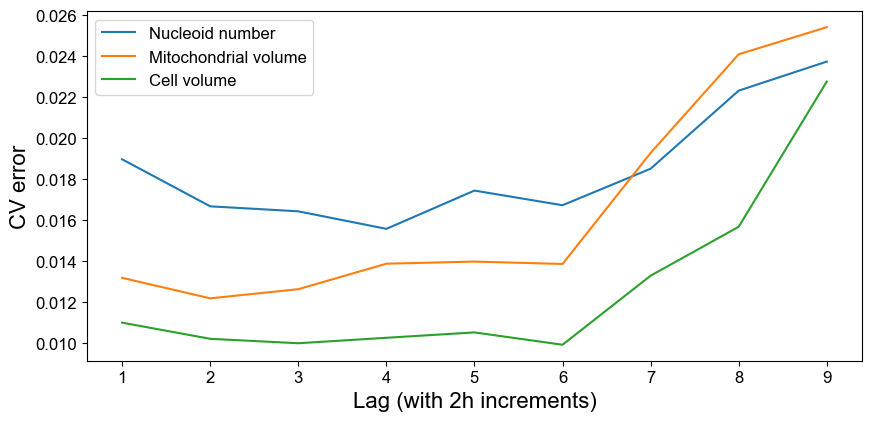

In [5]:
dna_CVs = []
mtvol_CVs = []
cellvol_CVs = []
for lag in range(9):
    print(lag+1)
    dna_CVs.append(dna_cross_validation(lag=lag+1))
    mtvol_CVs.append(mtvol_cross_validation(lag=lag+1))
    cellvol_CVs.append(cellvol_cross_validation(lag=lag+1))

plt.figure(1, figsize = (9,4.5))
plt.plot(np.arange(9)+1, dna_CVs, label = "Nucleoid number")
plt.plot(np.arange(9)+1, mtvol_CVs, label = "Mitochondrial volume")
plt.plot(np.arange(9)+1, cellvol_CVs, label = "Cell volume")
plt.ylabel("CV error")
plt.xlabel("Lag (with 2h increments)")
plt.legend()
plt.tight_layout()
print("DNA CV minimum lag = " + str(np.argmin(dna_CVs)+1))
print("mtvol CV minimum lag = " + str(np.argmin(mtvol_CVs)+1))
print("cell vol CV minimum lag = " + str(np.argmin(cellvol_CVs)+1))

Now computing Granger p-values using the above selected cross validation lags

In [6]:
response_vec, predictor_matrix = create_regression_matrices(4, response = "dna")
mod_DNA = sm.OLS(response_vec, predictor_matrix)
fii_DNA = mod_DNA.fit()
fii_DNA.summary2()
hypotheses = '(x5=0),(x6=0),(x7=0),(x8=0)'
f_test = fii_DNA.f_test(hypotheses)
print("mtvol->DNA significance:")
print(f_test)
hypotheses = '(x9=0),(x10=0),(x11=0),(x12=0)'
f_test = fii_DNA.f_test(hypotheses)
print("cellvol->DNA significance:")
print(f_test)

mtvol->DNA significance:
<F test: F=2.680225056083894, p=0.03366298634617728, df_denom=158, df_num=4>
cellvol->DNA significance:
<F test: F=1.132501875050366, p=0.34321260225896216, df_denom=158, df_num=4>


In [7]:
response_vec, predictor_matrix = create_regression_matrices(2, response = "mtvol")
mod_DNA = sm.OLS(response_vec, predictor_matrix)
fii_DNA = mod_DNA.fit()
fii_DNA.summary2()
hypotheses = '(x3=0),(x4=0)'
f_test = fii_DNA.f_test(hypotheses)
print("DNA->mtvol significance:")
print(f_test)
hypotheses = '(x5=0),(x6=0)'
f_test = fii_DNA.f_test(hypotheses)
print("cellvol->mtvol significance:")
print(f_test)

DNA->mtvol significance:
<F test: F=5.0382416304485185, p=0.007323935103150892, df_denom=202, df_num=2>
cellvol->mtvol significance:
<F test: F=0.41384941395194896, p=0.6616597386883949, df_denom=202, df_num=2>


In [8]:
response_vec, predictor_matrix = create_regression_matrices(6, response = "cellvol")
import statsmodels.api as sm
mod_DNA = sm.OLS(response_vec, predictor_matrix)
fii_DNA = mod_DNA.fit()
fii_DNA.summary2()
hypotheses = '(x7=0),(x8=0),(x9=0),(x10=0),(x11=0),(x12=0)'
f_test = fii_DNA.f_test(hypotheses)
print("DNA->cellvol significance:")
print(f_test)
hypotheses = '(x13=0),(x14=0),(x15=0),(x16=0),(x17=0),(x18=0)'
f_test = fii_DNA.f_test(hypotheses)
print("mtvol->cellvol significance:")
print(f_test)

DNA->cellvol significance:
<F test: F=2.1603784950493554, p=0.05190688010890104, df_denom=114, df_num=6>
mtvol->cellvol significance:
<F test: F=3.7366577206033877, p=0.0019770210557656354, df_denom=114, df_num=6>
